In [8]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_context(context="talk")

import os, re, sys
from keras.layers import CuDNNLSTM,CuDNNGRU

import pandas as pd
import ast, time
import matplotlib.pyplot as plt
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
import re, io, nltk, torch 
from numpy.linalg import norm
from tqdm import tqdm, trange
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from nltk.corpus import stopwords
from collections import Counter

from sklearn.utils import class_weight
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau    
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable


import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

stoplist = stopwords.words("english")

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def my_cleaner(post):      
    s= re.sub(r"http\S+", "html", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', "hashtag", s) ########3
    s= re.sub(r'@\w+ ?', "user", s)##############    
    s= s.lower()    
    s=emoji_pattern.sub(r'', s)
    sl= list(s.split())  
    sl=[word for word in sl if word not in stoplist]
    s=' '.join([word for word in s.split() if word not in stoplist])
    return s, sl

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        prob = self.model.predict(self.validation_data[0])
        predict = np.squeeze(prob>=0.5)*1
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def train_model(model, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=1, focal=False):
    if focal:
        model.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])
    else:
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    """
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)"""
    if not focal:
        hist=model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=verb, validation_data=(x_val,y_val), class_weight=class_weights, callbacks=calls)
    else:
        hist=model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=verb, validation_data=(x_val,y_val), callbacks=calls)
        
    plt.figure(figsize=(10,4))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F-score" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Val metrics")
    plt.legend(loc="upper left")
    plt.show()
    
    return model 

In [2]:
#qscd
d_lab=dict()
d_lab["questioning"]=0
d_lab["support"]=1
d_lab["commenting"]=2
d_lab["denying"]=3


In [3]:
train =pd.read_csv("../Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Stance/test_semeval_raw.csv")

print ("Conteo por stance\n", Counter(train['Label']))

dir_path='../../model_save/Dos-Fases-all_Stance/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 

idx_2_token = tokenizer_loaded.ids_to_tokens

archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}

M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
print ("M_BERT_space.shape", M_BERT_space.shape)



etiq=[]
for et in train['Label'].values:
    etiq.append(d_lab[et])
print ("etiq train [0:10]", etiq[0:10])
etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
print ("etiq val [0:10]", etiq_v[0:10])

etiq_t=[]
for et in test['Label'].values:
    etiq_t.append(d_lab[et])
print ("etiq val [0:10]", etiq_t[0:10])

n_labels_t = np.array(etiq_t)
y_test=to_categorical(n_labels_t,num_classes=4)

sentences = train['Tweet'].values
n_labels = np.array(etiq)

input_ids = []
for sent in sentences:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids.append(encoded_sent)
print('Max train sentence length: ', max([len(sen) for sen in input_ids]))

MAX_LEN = 50

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer_loaded.pad_token, tokenizer_loaded.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

n_labels = np.array(etiq)
n_labels_val = np.array(etiq_v)
y_train=to_categorical(n_labels,num_classes=4)
y_val=to_categorical(n_labels_val,num_classes=4)


class_weights = class_weight.compute_class_weight('balanced', np.unique(etiq), etiq)
print ("class_weights Training set", class_weights)

sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


Conteo por stance
 Counter({'commenting': 2734, 'support': 841, 'denying': 333, 'questioning': 330})
M_BERT_space.shape (30522, 768)
etiq train [0:10] [0, 2, 2, 1, 0, 0, 2, 2, 2, 2]
etiq val [0:10] [1, 2, 2, 2, 0, 1, 2, 2, 2, 2]
etiq val [0:10] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Max train sentence length:  51

Padding/truncating all sentences to 50 values...

Padding token: "[PAD]", ID: 0
class_weights Training set [3.21060606 1.25980975 0.38752743 3.18168168]


In [4]:
input_ids

array([[ 5310, 20330, 20464, ...,     0,     0,     0],
       [ 5310, 20330, 20330, ...,     0,     0,     0],
       [ 5310, 20330,  7875, ...,     0,     0,     0],
       ...,
       [ 5310, 20330, 20330, ...,     0,     0,     0],
       [ 5310,  8322,  2102, ...,     0,     0,     0],
       [ 5310,  2386,  2100, ...,     0,     0,     0]])

In [6]:
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], 768))
i=0
for in_id in input_ids:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_train[i]=(vector/n)
    i+=1   
    
    
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], 768))
i=0
for in_id in input_ids_val:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_val[i]=(vector/n)
    i+=1  
    
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], 768))
i=0
for in_id in input_ids_test:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_test[i]=(vector/n)
    i+=1  

In [7]:
del tokenizer_loaded 
del model_loaded 

#### In Table 1 we show the parameters of each architecture

CNN1

- 1 capa relu 
- out: softmax
- focal loss

CNN2 

- 2 capas relu 
- out: softmax
- focal loss

RNN1

- 2 capas gru
- out: softmax
- focal loss

RNN2

- 3 capas gru
- out: softmax
- focal loss


RNN3

- 3 capas gru
- out: softmax
- Categorical Cross Entropy



## Modelos base

In [12]:
sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
x_train_smote, y_train_smote = sm.fit_sample(x_train, y_train)

In [13]:
y_train_smote.shape

(10936, 4)

In [14]:
np.save("Data_SMOTE_AWE/x_train.npy", x_train_smote)
np.save("Data_SMOTE_AWE/y_train.npy", y_train_smote)
np.save("Data_SMOTE_AWE/x_val.npy", x_val)
np.save("Data_SMOTE_AWE/y_val.npy", y_val)
np.save("Data_SMOTE_AWE/x_test.npy", x_test)
np.save("Data_SMOTE_AWE/y_test.npy", y_test)

## CNN 1

In [4]:
x_train=np.load('Data_SMOTE_AWE/x_train.npy')
y_train=np.load('Data_SMOTE_AWE/y_train.npy')
x_val=np.load('Data_SMOTE_AWE/x_val.npy')
y_val=np.load('Data_SMOTE_AWE/y_val.npy')
x_test=np.load('Data_SMOTE_AWE/x_test.npy')
y_test=np.load('Data_SMOTE_AWE/y_test.npy')

In [5]:
etiq=[np.argmax(y) for y in y_train]
etiq_v=[np.argmax(y) for y in y_val]
etiq_t=[np.argmax(y) for y in y_test]

In [6]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(etiq), etiq)
print ("class_weights Training set", class_weights)

class_weights Training set [1. 1. 1. 1.]


In [7]:
x_new_train=np.expand_dims(x_train, axis=-1)
x_new_val=np.expand_dims(x_val, axis=-1)
x_new_test=np.expand_dims(x_test, axis=-1)

In [24]:
sequence_input = Input(shape=x_new_train.shape[1:])
batch = BatchNormalization()(sequence_input)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(100, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
cnn1 = Model(sequence_input, preds)


 - val_f1: 0.000000 
 - val_f1: 0.222874 
 - val_f1: 0.394774 
 - val_f1: 0.373969 
 - val_f1: 0.345357 
 - val_f1: 0.422628 
 - val_f1: 0.479376 
 - val_f1: 0.497947 
 - val_f1: 0.410832 
 - val_f1: 0.426414 
 - val_f1: 0.412705 
 - val_f1: 0.418247 
 - val_f1: 0.416309 
 - val_f1: 0.355507 
 - val_f1: 0.350664 
 - val_f1: 0.333799 
 - val_f1: 0.401680 
 - val_f1: 0.438386 
 - val_f1: 0.373297 
 - val_f1: 0.421329 
 - val_f1: 0.407167 
 - val_f1: 0.395085 
 - val_f1: 0.463711 
 - val_f1: 0.410785 
 - val_f1: 0.426831 
 - val_f1: 0.414194 
 - val_f1: 0.430508 
 - val_f1: 0.361161 
 - val_f1: 0.360356 
 - val_f1: 0.406714 


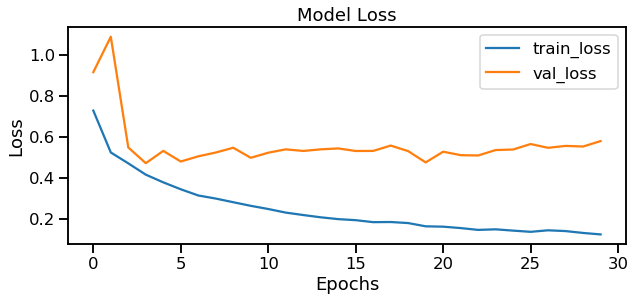

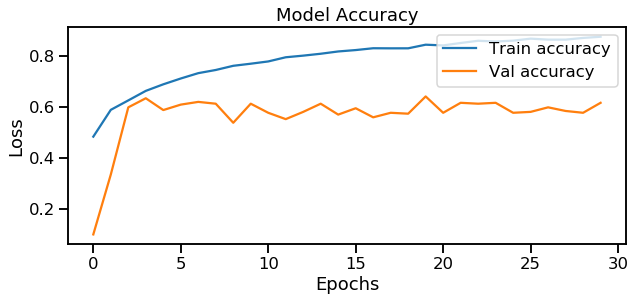

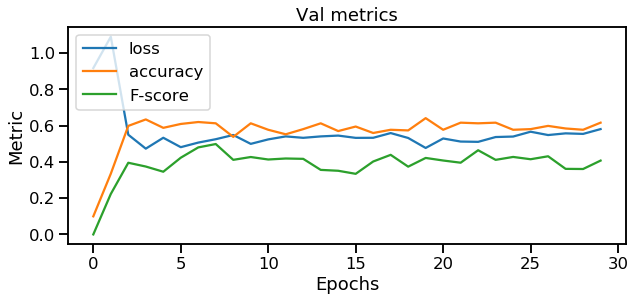

In [25]:
trained_awe =train_model(cnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

Accuracy sobre validacion CNN FOCAL: 0.7002938295788442
F1-score weighted sobre validación CNN FOCAL: [0.45853659 0.22972973 0.81979695 0.08849558]
F1-score macro sobre validación CNN FOCAL: 0.39913971115788577


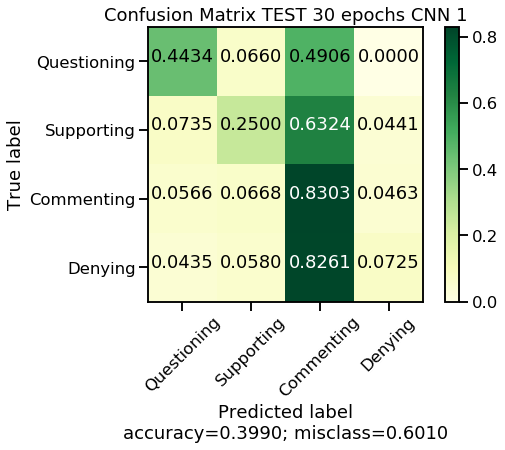

In [26]:
trainPredict = trained_awe.predict(x_new_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion CNN FOCAL:",acc_test)  
print ("F1-score weighted sobre validación CNN FOCAL:",f1_test)
print ("F1-score macro sobre validación CNN FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST 30 epochs CNN 1", cmap='YlGn')

trained_awe.save('baselines_fromCIARP_SMOTE/cnn1_AWE_30e_focal.h5') 


### CNN2

 - val_f1: 0.000000 
 - val_f1: 0.161211 
 - val_f1: 0.369444 
 - val_f1: 0.328350 
 - val_f1: 0.414190 
 - val_f1: 0.327718 
 - val_f1: 0.384372 
 - val_f1: 0.396651 
 - val_f1: 0.424658 
 - val_f1: 0.438209 
 - val_f1: 0.432068 
 - val_f1: 0.431387 
 - val_f1: 0.452268 
 - val_f1: 0.404579 
 - val_f1: 0.403986 
 - val_f1: 0.369998 
 - val_f1: 0.461613 
 - val_f1: 0.426568 
 - val_f1: 0.434415 
 - val_f1: 0.409982 
 - val_f1: 0.478103 
 - val_f1: 0.402547 
 - val_f1: 0.471926 
 - val_f1: 0.457249 
 - val_f1: 0.421023 
 - val_f1: 0.464369 
 - val_f1: 0.398142 
 - val_f1: 0.466925 
 - val_f1: 0.453284 
 - val_f1: 0.446444 


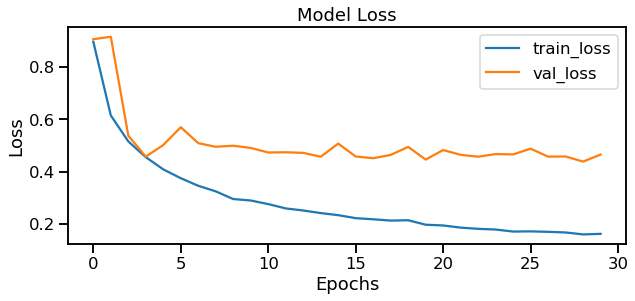

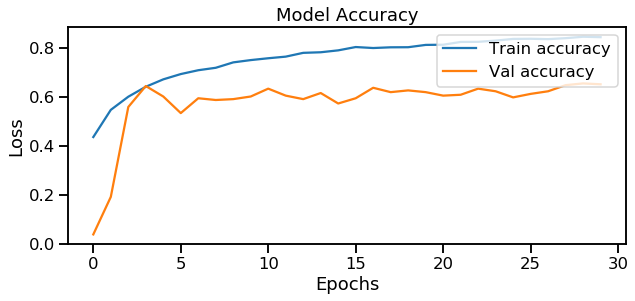

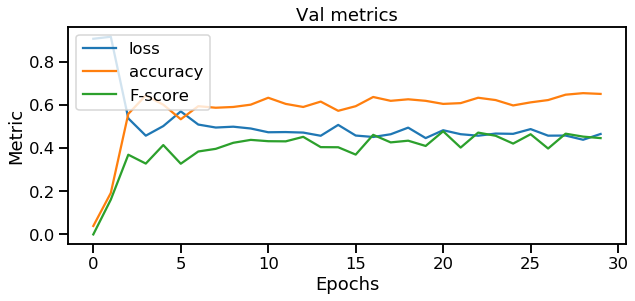

In [30]:
sequence_input = Input(shape=x_new_train.shape[1:])
batch = BatchNormalization()(sequence_input)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(128, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds= Dropout(0.3)(preds)
preds = Dense(4, activation='softmax')(preds)
cnn2 = Model(sequence_input, preds)

trained_awe =train_model(cnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

trained_awe.save('baselines_fromCIARP_SMOTE/cnn2_AWE_30e_focal.h5') 

Accuracy sobre validacion CNN 2 FOCAL: 0.6748285994123409
F1-score weighted sobre validación CNN 2 FOCAL: [0.49339207 0.26845638 0.79450262 0.08695652]
F1-score macro sobre validación CNN 2 FOCAL: 0.4108268964659213


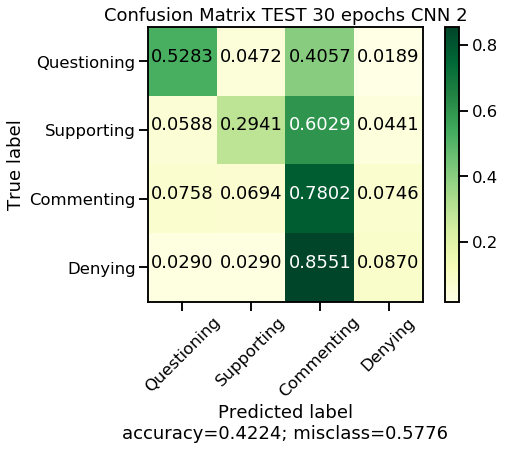

In [31]:
trainPredict = trained_awe.predict(x_new_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion CNN 2 FOCAL:",acc_test)  
print ("F1-score weighted sobre validación CNN 2 FOCAL:",f1_test)
print ("F1-score macro sobre validación CNN 2 FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST 30 epochs CNN 2", cmap='YlGn')


### RNN1

In [10]:
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical

from keras.layers import CuDNNLSTM,CuDNNGRU

def create_complex_GRU_2(unidades,unidades2,opt,input_s):
    model = Sequential()
    model.add(CuDNNGRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.45))
    model.add(BatchNormalization())
    model.add(CuDNNGRU(units=unidades2,return_sequences=False,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    #model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['acc'])
    return model

def create_complex_GRU_3(unidades,unidades2,unidades3,opt,input_s):
    model = Sequential()
    model.add(CuDNNGRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.65))
    model.add(BatchNormalization())
    model.add(CuDNNGRU(units=unidades2,return_sequences=True,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model.add(Dropout(0.45))
    model.add(BatchNormalization())
    model.add(CuDNNGRU(units=unidades3,return_sequences=False,input_shape=input_s ))#,
    model.add(Dropout(0.35))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    #model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['acc'])
    return model





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 - val_f1: 0.076923 
 - val_f1: 0.007042 
 - val_f1: 0.000000 
 - val_f1: 0.119949 
 - val_f1: 0.014085 
 - val_f1: 0.015666 
 - val_f1: 0.042857 
 - val_f1: 0.019540 
 - val_f1: 0.007143 
 - val_f1: 0.120069 
 - val_f1: 0.133907 
 - val_f1: 0.146042 
 - val_f1: 0.121774 
 - val_f1: 0.139197 
 - val_f1: 0.106555 
 - val_f1: 0.124824 
 - val_f1: 0.149292 
 - val_f1: 0.135146 
 - val_f1: 0.210064 
 - val_f1: 0.195877 
 - val_f1: 0.126090 
 - val_f1: 0.165031 
 - val_f1: 0.244608 
 - val_f1: 0.189955 
 - val_f1: 0.234786 
 - val_f1: 0.253437 
 - val_f1: 0.220140 
 - val_f1: 0.216177 
 - val_f1: 0.285924 
 - val_f1: 0.249547 


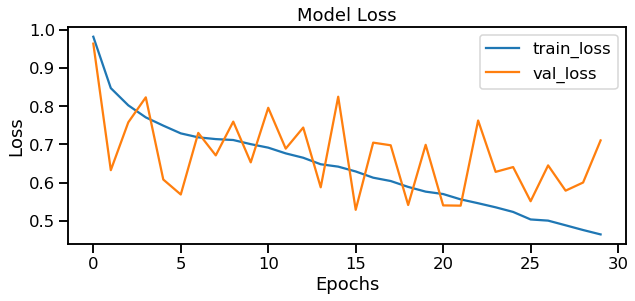

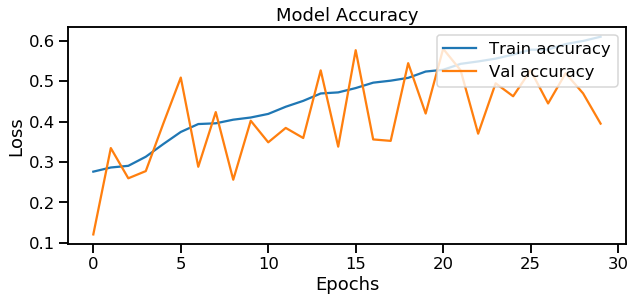

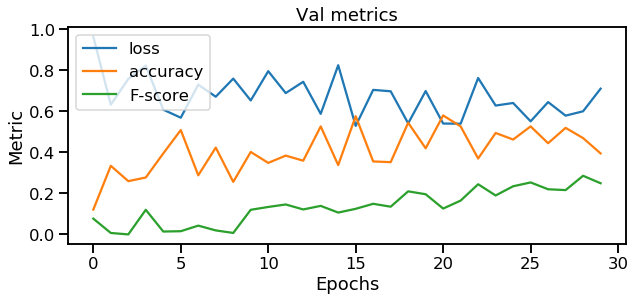

Accuracy sobre validacion RNN 1 FOCAL: 0.32615083251714005
F1-score weighted sobre validación RNN 1 FOCAL: [0.22843823 0.10655738 0.46503179 0.1119403 ]
F1-score macro sobre validación RNN 1 FOCAL: 0.2279919233193355


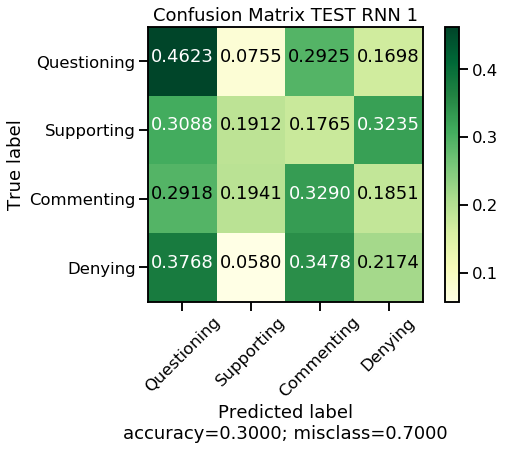

In [11]:
rnn1 = create_complex_GRU_2(128,64,"adam",x_new_train.shape[1:])
trained_awe =train_model(rnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

trainPredict = trained_awe.predict(x_new_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion RNN 1 FOCAL:",acc_test)  
print ("F1-score weighted sobre validación RNN 1 FOCAL:",f1_test)
print ("F1-score macro sobre validación RNN 1 FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST RNN 1", cmap='YlGn')

trained_awe.save('baselines_fromCIARP_SMOTE/rnn1_AWE_30e_focal.h5') 

In [12]:
del trained_awe

### RNN2

 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.101942 
 - val_f1: 0.000000 
 - val_f1: 0.007042 
 - val_f1: 0.033333 
 - val_f1: 0.033333 
 - val_f1: 0.053571 
 - val_f1: 0.128788 
 - val_f1: 0.146148 
 - val_f1: 0.109829 
 - val_f1: 0.165648 
 - val_f1: 0.207477 
 - val_f1: 0.161860 
 - val_f1: 0.214750 
 - val_f1: 0.187117 


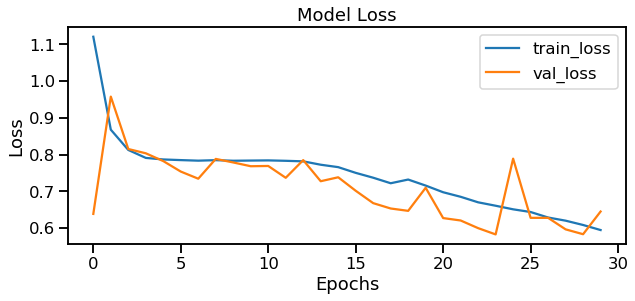

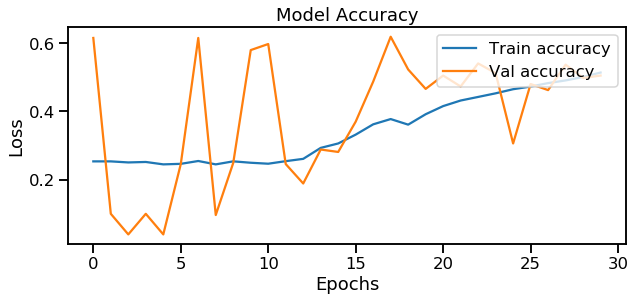

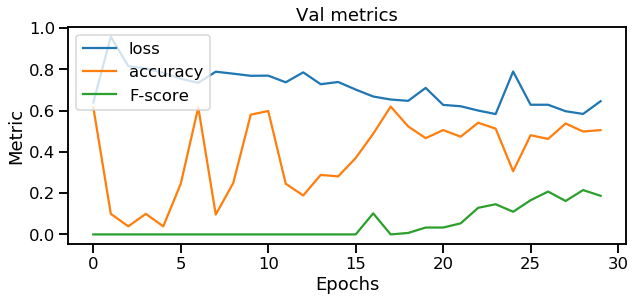

In [13]:
rnn2 = create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])

trained_awe =train_model(rnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)

trained_awe.save('baselines_fromCIARP_SMOTE/rnn2_AWE_30e_focal.h5')  

Accuracy sobre validacion RNN 2 FOCAL: 0.4201762977473066
F1-score weighted sobre validación RNN 2 FOCAL: [0.25185185 0.14634146 0.58709677 0.09090909]
F1-score macro sobre validación RNN 2 FOCAL: 0.26904979509228133


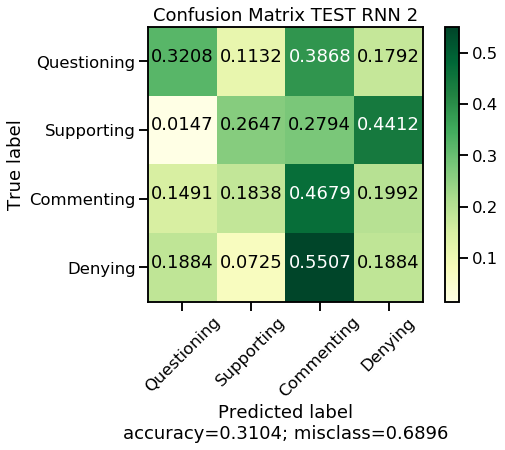

In [14]:
trainPredict = trained_awe.predict(x_new_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion RNN 2 FOCAL:",acc_test)  
print ("F1-score weighted sobre validación RNN 2 FOCAL:",f1_test)
print ("F1-score macro sobre validación RNN 2 FOCAL:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST RNN 2", cmap='YlGn')


del trained_awe

### RNN3

 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.000000 
 - val_f1: 0.014085 
 - val_f1: 0.123913 
 - val_f1: 0.115385 
 - val_f1: 0.031036 
 - val_f1: 0.192679 
 - val_f1: 0.204382 
 - val_f1: 0.199162 
 - val_f1: 0.278389 
 - val_f1: 0.309430 
 - val_f1: 0.275561 
 - val_f1: 0.323080 
 - val_f1: 0.338634 
 - val_f1: 0.304236 
 - val_f1: 0.318040 
 - val_f1: 0.296901 
 - val_f1: 0.310181 
 - val_f1: 0.386956 
 - val_f1: 0.362376 


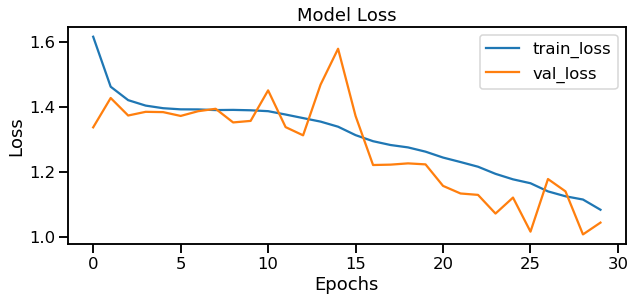

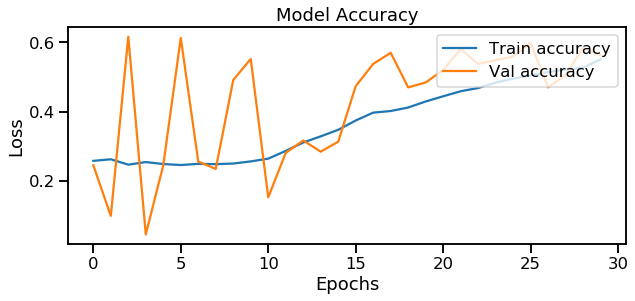

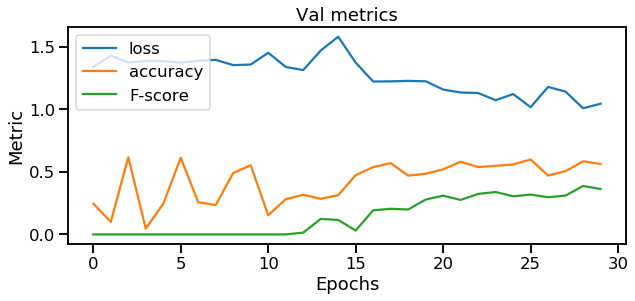

In [15]:
rnn3 = create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])

trained_awe =train_model(rnn3, x_new_train, y_train, x_new_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)

trained_awe.save('baselines_fromCIARP_SMOTE/rnn3_awe_30e_cce.h5')  #CCE

Accuracy sobre validacion RNN CCe: 0.5876591576885406
F1-score weighted sobre validación RNN CCE: [0.27074236 0.09333333 0.74762551 0.11640212]
F1-score macro sobre validación RNN CCE: 0.3070258291583977


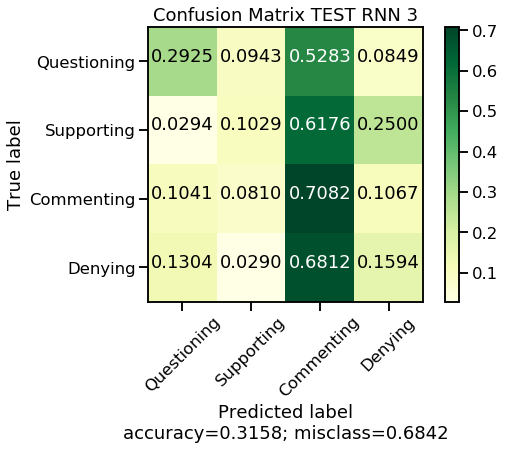

In [16]:
trainPredict = trained_awe.predict(x_new_test, batch_size=32)
trainPredict=[np.argmax(pred) for pred in trainPredict]
acc_test= accuracy_score(etiq_t, trainPredict)  
f1_test=f1_score(etiq_t, trainPredict, average=None)  
f1_test_ma=f1_score(etiq_t, trainPredict, average='macro') 

matriz_test=confusion_matrix(etiq_t, trainPredict)
print ("Accuracy sobre validacion RNN CCe:",acc_test)  
print ("F1-score weighted sobre validación RNN CCE:",f1_test)
print ("F1-score macro sobre validación RNN CCE:",f1_test_ma)
plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST RNN 3", cmap='YlGn')


### Committee

In [3]:
cnn1= load_model('baselines_fromCIARP_SMOTE/cnn1_AWE_30e_focal.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})  
cnn2= load_model('baselines_fromCIARP_SMOTE/cnn2_AWE_30e_focal.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
rnn1= load_model('baselines_fromCIARP_SMOTE/rnn1_AWE_30e_focal.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
rnn2= load_model('baselines_fromCIARP_SMOTE/rnn2_AWE_30e_focal.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
rnn3= load_model('baselines_fromCIARP_SMOTE/rnn3_AWE_30e_cce.h5') 

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [ ]:
list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
index_models=np.arange(5)
dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
ind=np.arange(5)
dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))


In [ ]:
bs=32
for i in dict_trainedModel.keys(): 
    print ("Agregando predicciones val del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    predicho=dict_trainedModel[i].predict(x_new_test, batch_size=bs)
    predicho=[np.argmax(pred) for pred in predicho]
    acc= accuracy_score(etiq_t, predicho)  
    f1_ma=f1_score(etiq_t, predicho, average='macro')
    f1_no=f1_score(etiq_t, predicho, average=None)

    print ("Accuracy:",acc)  
    print ("F1-score:",f1_ma)
    print ("F1-score none average:",f1_no)

    matriz_test=confusion_matrix(etiq_t, predicho)
    plot_confusion_matrix(normalize(matriz_test,axis=1,norm='l1'),["NonH","IndirectH","PhysicalH","SexualH"],"Confusion Matrix Test set")
    
#qscd

In [ ]:
predicciones_all_test=[]

bs=32
for i in dict_trainedModel.keys(): 
    print ("Agregando predicciones val del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    predicciones_all_test.append(dict_trainedModel[i].predict(x_new_test, batch_size=bs))
        
predichos_all_test=np.concatenate(np.asarray(predicciones_all_test),axis=-1)
predichos_all_test.shape

In [ ]:
def predecir_modelos(bs,predichos_all):  #best fit
    temp=predichos_all.copy()
    final=[np.argmax(pred) for pred in temp]  
    confianzas=[temp[i][final[i]] for i in range(len(final))]
    predichos_new=[]
    for i in range(len(temp)):
        indice=final[i]%4
        predichos_new.append(int(indice))
    return predichos_new,final,confianzas    

def predecir_modelos_norm(bs,predichos_all):  #normalizado
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:   
        aux=np.ones(4)
        for i in range(1,6): #for machine pred
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux*np.asarray(sub)
            
        aux=aux/np.sum(aux)
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas
    
def predecir_modelos_average(bs,predichos_all): #average
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:
        aux=np.zeros(4)
        for i in range(1,6):
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux+np.asarray(sub)
            
        aux=aux/5.0 #dividido en el total de machines
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas

In [ ]:
batchSize=32

print ("\nCommittee Best Fit")
trainPredicho, maxPredicho, confianzas = predecir_modelos(batchSize,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy test del comité:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-score macro test del comité:",f1)
f1=f1_score(etiq_t, trainPredicho, average=None)  
print("F1-score none SDQC:",f1)

print ("\nCommittee Norm")
trainPredicho, maxPredicho, confianzas = predecir_modelos_norm(batchSize,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy test del comité:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-score macro test del comité:",f1)
f1=f1_score(etiq_t, trainPredicho, average=None) 
print("F1-score none SDQC:",f1)

print ("\nCommittee Voting")
trainPredicho, maxPredicho, confianzas = predecir_modelos_average(batchSize,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy test del comité:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-score macro test del comité:",f1)
f1=f1_score(etiq_t, trainPredicho, average=None)  
print("F1-score none SDQC:",f1)